<font color='tomato'><font color="#CC3D3D"><p>
# All-in-One Model without Ensemble

<img align='left' src='http://drive.google.com/uc?export=view&id=11E7qOZLk71hpWdhp3avlT4OkxIwme6it' width=800>

### Imports

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import keras

from keras.preprocessing import sequence
from keras.preprocessing.text import *

In [3]:
from keras.models import Model
from keras import Input
from keras import layers
from keras import regularizers
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping

### Read data

In [4]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


## 1) Categorical

### Transform data

In [5]:
max_features = 100000
max_len = 100
emb_dim = 128 

* low level: goods_id

In [6]:
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space
df_train.goods_id = df_train.goods_id.apply(lambda x: str(x))
df_test.goods_id = df_test.goods_id.apply(lambda x: str(x))
X_train = df_train.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_low = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_low = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_low.shape, X_test_low.shape

((3500, 100), (2482, 100))

* middle level: gds_grp_nm

In [7]:
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values

# Pads sequences to the same length
X_train_mid = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_mid = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_mid.shape, X_test_mid.shape

((3500, 100), (2482, 100))

* high level: gds_grp_mclas_nm

In [8]:
# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_high = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_high.shape, X_test_high.shape

((3500, 100), (2482, 100))

* store

In [9]:
# Converts a "store_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_str = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_str = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_str.shape, X_test_str.shape

((3500, 100), (2482, 100))

## 2) Numerical (Automated FE)

### Prepare data

In [10]:
df = pd.concat([df_train, df_test]).reset_index(drop=True).reset_index().rename(columns={'index': 'trans_id'})
#drop categorical values(store_nm, goods_id, gds_grp_nm, gds_grp_mclas_nm)
df.drop(columns=['store_nm','goods_id','gds_grp_nm','gds_grp_mclas_nm'], inplace=True)
#standardize amount variable
df['amount']=((df['amount']-df['amount'].min())/(df['amount'].max()-df['amount'].min()))
df.head()

,trans_id,cust_id,tran_date,amount
0,0,0,2007-01-19 00:00:00,0.298172
1,1,0,2007-03-30 00:00:00,0.297804
2,2,0,2007-03-30 00:00:00,0.300310
3,3,0,2007-03-30 00:00:00,0.298162
4,4,0,2007-03-30 00:00:00,0.297346


In [11]:
# A dataframe to create a feature matrix for each customer 
cu = pd.DataFrame({'cust_id': df.cust_id.unique()})

# Specify a dictionary with all the entities
entities = {
    "cust": (cu, "cust_id"),
    "trans": (df, "trans_id")
}

# Specify how the entities are related
relationships = [
    ("cust", "cust_id", "trans", "cust_id")
]

### Run Deep Feature Synthesis

In [12]:
derived_features, _ = ft.dfs(entities=entities, relationships=relationships, target_entity="cust")
derived_features = derived_features.fillna(0)

In [13]:
np.asarray(derived_features).shape

(5982, 15)

In [14]:
X_train_num = np.asarray(derived_features[0:3500])
X_test_num = np.asarray(derived_features[3500:5983])

X_train_num.shape, X_test_num.shape

((3500, 15), (2482, 15))

## 3) W2V (텍스트)

### Make corpus

In [15]:
p_level = 'gds_grp_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
def oversample(x, n):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

X_train = list(df_train.groupby('cust_id')[p_level].agg(oversample, 20))
X_test = list(df_test.groupby('cust_id')[p_level].agg(oversample, 20))

### Training the Word2Vec model

In [16]:
num_features = 100 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(X_train, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,)
# 필요없는 메모리 unload
model.init_sims(replace=True)
#model.wv.most_similar('여자',topn=20)

### Making X_train_w2v

In [17]:
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.min([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ])
X_train_w2v = EmbeddingVectorizer(model.wv).transform(X_train)
X_test_w2v = EmbeddingVectorizer(model.wv).transform(X_test)

## 4) Conv2D (이미지)

<img align='left' src='http://drive.google.com/uc?export=view&id=1MSaW9Et8ny5k1kpdjtw4LGGFEbCZSUX3' width=700>

### Transform data

In [18]:
df=pd.concat([df_train,df_test],sort=False)
#standardize amount variable
df["amount"]=((df["amount"]-df["amount"].min())/(df["amount"].max()-df["amount"].min()))
#remove time from 'tran_date'
df['tran_date']=df['tran_date'].apply(lambda x: x[:10])
df['tran_date']=pd.to_datetime(df['tran_date'])

In [19]:
#Make blank one_year dataframe
import datetime

start = datetime.datetime.strptime("01-01-2007", "%d-%m-%Y")
end = datetime.datetime.strptime("07-01-2008", "%d-%m-%Y")
year_2017 = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

one_year = pd.DataFrame({'tran_date':year_2017})

one_year = pd.concat([
    pd.DataFrame(
        {'tran_date': row.tran_date,
         'nth': range(1,11)
        }
    ) for i, row in one_year.iterrows()
], ignore_index=True).loc[:, ['tran_date','nth']]

def wk_num(date):
    weekNumber = date.isocalendar()[1]+(date.isocalendar()[0]-2007)*52
    return weekNumber

one_year['week_number']= one_year['tran_date'].apply(lambda x: wk_num(x))

def wk_day(date):
    return date.weekday()

one_year['week_day']= one_year['tran_date'].apply(lambda x: wk_day(x))

one_year.head()

,tran_date,nth,week_number,week_day
0,2007-01-01,1,1,0
1,2007-01-01,2,1,0
2,2007-01-01,3,1,0
3,2007-01-01,4,1,0
4,2007-01-01,5,1,0


In [20]:
df['index']=df.index
df['nth'] = df.groupby(['cust_id','tran_date'])['index'].rank(ascending=True)
df.drop(columns='index',inplace=True)
df.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,nth
0,0,2007-01-19,강남점,127105,기초 화장품,화장품,0.298172,1.0
1,0,2007-03-30,강남점,342220,니 트,시티웨어,0.297804,1.0
2,0,2007-03-30,강남점,127105,기초 화장품,화장품,0.300310,2.0
3,0,2007-03-30,강남점,342205,니 트,시티웨어,0.298162,3.0
4,0,2007-03-30,강남점,342220,상품군미지정,기타,0.297346,4.0


### Making Corpus

In [21]:
#p_level = 'goods_id'
#df_train[p_level]=df_train[p_level].astype('str')
p_level = 'gds_grp_nm'  # 상품 분류 수준
#p_level = 'gds_grp_mclas_nm'


# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
def oversample(x, n):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

gds_train = list(df_train.groupby(['cust_id'])[p_level].agg(oversample, 20))
gds_test = list(df_test.groupby(['cust_id'])[p_level].agg(oversample, 20))

### Training the Word2Vec model

In [22]:
num_features = 10 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model1 = word2vec.Word2Vec(gds_train, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,)
# 필요없는 메모리 unload
model1.init_sims(replace=True)
#model.wv.most_similar('여자',topn=20)

In [23]:
#Make X_train_conv2d and X_test_conv2d
train = []
test = []

cust_id=df['cust_id'].unique()
for cust in cust_id:
    f = df[df['cust_id']==cust]
    f = pd.merge(one_year,f,how="left").fillna(0)
    f[p_level]=f[p_level].astype('str')
    amount=np.asarray(f.amount).reshape((53,70))
    if(cust<3500):
        #train.append(goods_id)
        #train.append(gds_grp_nm)
        #train.append(gds_grp_mclas_nm)
        train.append(amount)
        for i in range(10):
            gds=[]
            for w in f[p_level]:
                if w in model1.wv:
                    gds.append(model1.wv[w][i])
                    #print(model.wv[w][i])
                else:
                    gds.append(0)
                    #print(0)
            gds_array=np.asarray(gds).reshape((53,70))
            train.append(gds_array)

    else:
        test.append(amount)
        for i in range(10):
            gds=[]
            for w in f[p_level]:
                if w in model1.wv:
                    gds.append(model1.wv[w][i])
                    #print(model.wv[w][i])
                else:
                    gds.append(0)
                    #print(0)
            gds_array=np.asarray(gds).reshape((53,70))
            test.append(gds_array)

X_train_conv2d=np.asarray(train).reshape(len(df_train['cust_id'].unique()),11,53,70)
X_test_conv2d=np.asarray(test).reshape(len(df_test['cust_id'].unique()),11,53,70)

## 5) Conv1D (텍스트)

### Transform data

In [24]:
max_features1 = 100000
max_len = 100
emb_dim = 128

# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features1)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features1)[0] for i in x]).values

for i in range(X_train.shape[0]):
    x = np.unique(X_train[i])
    y = np.array([])
    for j in range(5):
        y = np.append(y, np.random.choice(x, len(x), replace=False))
    X_train[i] = y    
#    X_train[i] = np.random.choice(x, len(x), replace=False)

for i in range(X_test.shape[0]):
    x = np.unique(X_test[i])
    y = np.array([])
    for j in range(5):
        y = np.append(y, np.random.choice(x, len(x), replace=False))
    X_test[i] = y    
#    X_test[i] = np.random.choice(x, len(x)*5)    
    
# Pads sequences to the same length
X_train_conv1d = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_conv1d = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_conv1d.shape, X_test_conv1d.shape

((3500, 100), (2482, 100))

## 6) One-Hot + AE

### Transform data

In [25]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

### Reduce Dimensionality using Autoencoder




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4179)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2140160   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3

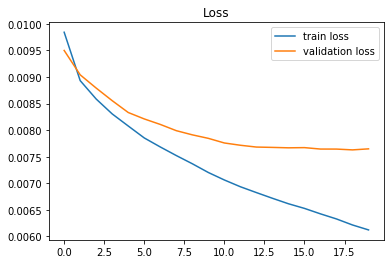

In [26]:
# Define the number of features
max_features2 = train.shape[1]

# Define the encoder dimension
encoding_dim = 128

# Input Layer
input_dim = Input(shape = (max_features2, ))

# Encoder Layers
encoded1 = layers.Dense(512, activation = 'relu')(input_dim)
encoded2 = layers.Dense(256, activation = 'relu')(encoded1)
encoded3 = layers.Dense(128, activation = 'relu')(encoded2)
encoded4 = layers.Dense(encoding_dim, activation = 'relu')(encoded3)

# Decoder Layers
decoded1 = layers.Dense(128, activation = 'relu')(encoded4)
decoded2 = layers.Dense(256, activation = 'relu')(decoded1)
decoded3 = layers.Dense(512, activation = 'relu')(decoded2)
decoded4 = layers.Dense(max_features2, activation = 'linear')(decoded3)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded4)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer = 'adam', loss = 'mse')

# Train the model
history = autoencoder.fit(train, train, epochs=20, batch_size=64, 
                          shuffle=True, validation_data=(test,test))

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

In [27]:
# Use a middle Bottleneck Layer to Reduce Dimension
hidden_act = [encoded4] #[encoded1, encoded2, encoded3, decoded1, decoded2]
for ix, act in enumerate(hidden_act):
    model2 = Model(inputs=input_dim, outputs=act)
    if ix == 0: 
        X_train_AE = model2.predict(train)
        X_test_AE = model2.predict(test)
    else:
        X_train_AE = np.hstack([X_train, model2.predict(train)])
        X_test_AE = np.hstack([X_test, model2.predict(test)])

max_f = X_train_AE.shape[1]
        
X_train_AE.shape, X_test_AE.shape

((3500, 128), (2482, 128))

### Build Model

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
low (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
mid (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
high (InputLayer)               (None, 100)          0                                            
__________________________________________________________________________________________________
store (InputLayer)              (None, 100)          0                                            
____________________________________________________________________________________________

Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 16s 6ms/step - loss: 2.5682 - acc: 0.5050 - val_loss: 1.2134 - val_acc: 0.5386
Epoch 2/50
2800/2800 [==============================] - 8s 3ms/step - loss: 2.5727 - acc: 0.5239 - val_loss: 1.2001 - val_acc: 0.5429
Epoch 3/50
2800/2800 [==============================] - 8s 3ms/step - loss: 2.4774 - acc: 0.5357 - val_loss: 1.1826 - val_acc: 0.5500
Epoch 4/50
2800/2800 [==============================] - 8s 3ms/step - loss: 2.4492 - acc: 0.5211 - val_loss: 1.1625 - val_acc: 0.5571
Epoch 5/50
2800/2800 [==============================] - 8s 3ms/step - loss: 2.5076 - acc: 0.5221 - val_loss: 1.1499 - val_acc: 0.5614
Epoch 6/50
2800/2800 [==============================] - 8s 3ms/step - loss: 2.3938 - acc: 0.5268 - val_loss: 1.1355 - val_acc: 0.5586
Epoch 7/50
2800/2800 [==============================] - 8s 3ms/step - loss: 2.2908 - acc: 0.5468 - val_loss: 1.1192 - val_acc: 0.5643
Epoch 8/50
280

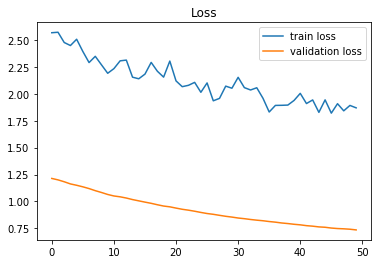

Wall time: 7min 37s


In [36]:
%%time

# 1) Categorical
# Define the Model & its Architecture
in_low = Input(shape=(max_len,), dtype='int32', name='low')
x = layers.Embedding(max_features, emb_dim)(in_low)
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_low = layers.Dropout(0.2)(x)

in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
x = layers.Embedding(max_features//10, emb_dim)(in_mid)
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_mid = layers.Dropout(0.2)(x)

in_high = Input(shape=(max_len,), dtype='int32', name='high')
x = layers.Embedding(max_features//100, emb_dim)(in_high)
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_high = layers.Dropout(0.2)(x)

in_str = Input(shape=(max_len,), dtype='int32', name='store')
x = layers.Embedding(max_features//100, emb_dim)(in_str)
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_str = layers.Dropout(0.2)(x)

x = layers.add([out_low, out_mid, out_high, out_str])
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_cat = layers.Dropout(0.5)(x)

# 2) Numerical
in_num = Input(shape=(15,), dtype='float', name='num')
x = layers.Dense(1, activation='sigmoid')(in_num)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_num = layers.Dropout(0.5)(x)

# 3) W2V
in_w2v = Input(shape=(300,), dtype='float', name='w2v')
x = layers.Dense(1, activation='sigmoid')(in_w2v)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_w2v = layers.Dropout(0.5)(x)

# 4) Conv2D
in_conv2d = Input(shape=(11,53,70), dtype='float', name='conv2d')
x = layers.Conv2D(1, kernel_size=(4,4),strides=(2,2), activation='tanh', padding='same', data_format = 'channels_first')(in_conv2d)
x = layers.Conv2D(1, kernel_size=(1,1),strides=(1,1), activation='tanh')(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_conv2d = layers.Dropout(0.5)(x)

# 5) Conv1D
in_conv1d = Input(shape=(max_len,), dtype='int32', name='conv1d')
x = layers.Embedding(max_features, emb_dim)(in_conv1d)
x = layers.Conv1D(32, 3, activation='elu')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(32, 3, activation='elu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_conv1d = layers.Dropout(0.5)(x)

# 6) One-hot Encoding + AE
in_AE = Input(shape=(max_f,), dtype='float', name='AE')
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(in_AE)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
out_AE = layers.Dropout(0.5)(x)


# Merge above 1~6
x = layers.add([out_cat, out_num, out_w2v, out_conv2d, out_conv1d, out_AE])
x = layers.Dense(1, activation='sigmoid')(x)
x = layers.PReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1, activation='sigmoid')(x)

out = layers.Dropout(0.2)(x)

model = Model([in_low, in_mid, in_high, in_str, in_num, in_w2v, in_conv2d, in_conv1d, in_AE], out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit([X_train_low, X_train_mid, X_train_high, X_train_str, X_train_num, X_train_w2v, X_train_conv2d, X_train_conv1d, X_train_AE], y_train, epochs=50, batch_size=128, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Submission file

In [37]:
pred = model.predict([X_test_low, X_test_mid, X_test_high, X_test_str, X_test_num, X_test_w2v, X_test_conv2d, X_test_conv1d, X_test_AE])[:,0]
fname = 'all_in_one_submit.csv'
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'all_in_one_submit.csv' is ready to submit.


<font color='tomato'><font color="#CC3D3D"><p>
# End